## Checking Bolton Approximation for $\sigma_{LCL}$
We want to approximate the $\sigma_{LCL} = p_{LCL}/p_s$ level in terms of just pseudo relative humidity, $r_s = q_s / q^*(T_s, p_s)$. Here, we evaluate the simple approximation derived from Equation 22 of Bolton 1980:

$$\frac{p_{LCL}}{p_s} \approx r_s^{\nu}$$

where $\nu = \frac{c_p}{2840 R} \frac{(T_s - 55)^2}{T_s}$ and $T_s$ is surface temperature.

The dependence on surface temperature is weak, so we just providing a reasonable guess, so LCL variation is then just in terms of relative humidity.

The error is small, with the major error for dry days, maybe as expected.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from isca_tools.convection.base import lcl_metpy, lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize
from isca_tools.utils.moist_physics import sphum_sat

In [14]:
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [46]:
temp_surf = np.linspace(270, 330, 61)
rh_surf = np.linspace(1, 100, 100)/100
p_surf = 1000 * 100
sphum_surf = sphum_sat(temp_surf, p_surf)
temp_surf_bolton_use = np.median(temp_surf)

In [53]:
temp_use, rh_use = np.meshgrid(temp_surf, rh_surf, indexing='xy')
sigma_metpy = lcl_metpy(temp_use, rh_use * sphum_sat(temp_use, p_surf), p_surf)[0]/p_surf
sigma_bolton = lcl_sigma_bolton_simple(rh_use, temp_surf_bolton_use)

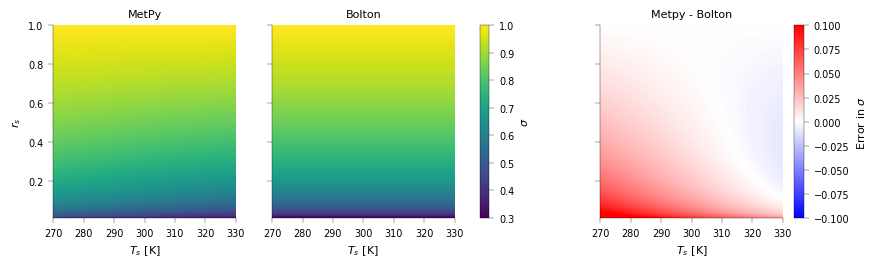

In [54]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 10)

# Plot sigma_metpy
im0 = ax[0].imshow(sigma_metpy, origin='lower',
                   extent=[temp_use.min(), temp_use.max(), rh_use.min(), rh_use.max()],
                   aspect='auto', cmap='viridis', vmin=0.3, vmax=1)
ax[0].set_title('MetPy')
ax[0].set_xlabel('$T_s$ [K]')
ax[0].set_ylabel('$r_s$')

# Plot sigma_bolton
im1 = ax[1].imshow(sigma_bolton, origin='lower',
                   extent=[temp_use.min(), temp_use.max(), rh_use.min(), rh_use.max()],
                   aspect='auto', cmap='viridis', vmin=0.3, vmax=1)
ax[1].set_title('Bolton')
ax[1].set_xlabel('$T_s$ [K]')
fig.colorbar(im1, ax=ax[:2].ravel(), label='$\sigma$')


# Plot sigma_bolton
im1 = ax[2].imshow(sigma_metpy - sigma_bolton, origin='lower',
                   extent=[temp_use.min(), temp_use.max(), rh_use.min(), rh_use.max()],
                   aspect='auto', cmap='bwr', vmin=-0.1, vmax=0.1)
ax[2].set_title('Metpy - Bolton')
ax[2].set_xlabel('$T_s$ [K]')
fig.colorbar(im1, ax=ax[2:], label='Error in $\sigma$')
plt.show()